# Fisher Information

Autodiff doesn't just make it faster to solve optimization and inference problems - it also allows you to use powerful ideas in statistics that require second derivatives that are intractable analytically or with finite differences.

The Fisher Information Matrix, or the inverse of the Hessian of the likelihood, can be used for
- the [Laplace approximation](https://www.sciencedirect.com/topics/mathematics/laplace-approximation) to a posterior for variational inference, giving you the Gaussian covariance of the posterior near the maximum likelihood point;
- Fisher forecasting, where you calculate this for an instrument or experiment at expected parameters, to predict how well it will constrain them; and
- optimal design, as the [Cramér-Rao lower bound](https://en.wikipedia.org/wiki/Cram%C3%A9r%E2%80%93Rao_bound) on the precision of an experiment is the inverse of the Fisher information matrix - so you want to make this as tight as possible!

Because `jax` lets us compute the Hessian of our loss function, we can use the Fisher matrix for variational inference without MCMC, and also more powerfully _as an objective function_ to optimize a telescope design: why bother engineering a PSF for a particular goal, when you could model the system _end to end_ and optimize the precision of the Fisher forecast of the parameter of interest?

* This is the topic of a Desdoigts et al paper in prep. It wasn't quite that easy to build and we're pretty happy about it.

This notebook follows on from [Phase Mask Design](designing_a_mask.ipynb) and will reuse some of the same code without repeating explanations.

Right, let's import some things.

In [1]:
import jax
import jax.numpy as np
import optax
import equinox as eqx
from tqdm.notebook import tqdm
import numpy as onp
import matplotlib.pyplot as plt

import dLux as dl
from dLux.helpers import *
from dLux.utils.bayes import *
from dLux.zernike import zernike_basis
from dLux.utils.models import toliman_layers # pre-built Toliman pupils
from chainconsumer import ChainConsumer

%matplotlib inline
plt.rcParams['image.cmap'] = 'inferno'
plt.rcParams["text.usetex"] = 'true'
plt.rcParams['figure.dpi'] = 120
plt.rcParams['savefig.facecolor'] = 'w'
onp.random.seed(1)

/Users/louis/mambaforge/envs/dlux/lib/python3.10/site-packages/jax/_src/lib/__init__.py:34: UserWarning: JAX on Mac ARM machines is experimental and minimally tested. Please see https://github.com/google/jax/issues/5501 in the event of problems.
  warnings.warn("JAX on Mac ARM machines is experimental and minimally tested. "


In [2]:
r = arcsec2rad(10)
positions = np.array([[r/2, 0], [-r/2, 0]])
fluxes = np.array([1e6, 1e6])
wavels = 1e-9 * np.linspace(545, 645, 9)

In [3]:
# Base layers
lays = toliman_layers()
aperture = lays[2].array
wf_npix = aperture.shape[0]

# # Zernike Basis
zern_basis = zernike_basis(10, wf_npix, outside=0.)[3:]
zcoeffs = np.zeros(len(zern_basis))

# Detector Layers
jitter = 1.
saturation = 1e6
det_layers = [dl.ApplyJitter(jitter), dl.ApplySaturation(saturation)]
det_layers = []

Load the saved basis vectors from the tutorial on [designing a mask](../designing_a_mask.ipynb).

In [4]:
basis = np.load("files/basis.npy")
wavels = 1e-9 * np.linspace(595, 695, 6)

Define the coordinate grid of the basis vectors:

In [5]:
ppf = get_ppf(wavels)
min_fringe = 1
max_fringe = 10

rmin = min_fringe/ppf
rmax = max_fringe/ppf
print(rmin, rmax)

5.2393847 52.39385


Generate a random pupil using CLIMB and random basis coefficients:

In [6]:
onp.random.seed(0)
coeffs = norm_rand(0, 100, [len(basis)])

latent_layers = toliman_layers([
                        dl.ApplyBasisCLIMB(basis, coeffs, np.mean(wavels)),
                        dl.ApplyBasisOPD(zern_basis, zcoeffs)],
                        det_npix=200)
osys = dl.OpticalSystem(latent_layers, 
                            wavels=wavels, 
                            positions=positions, 
                            fluxes=fluxes,
                            detector_layers=det_layers)

Visualize the PSF:

Text(0.5, 1.0, 'Input PSF')

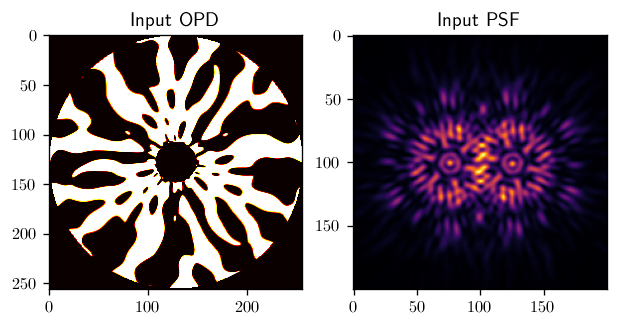

In [7]:
psf = osys()

fig, (ax1,ax2) = plt.subplots(1,2,figsize=(6.0,3.3))
ax1.imshow(osys.layers[2].array*osys.layers[4].get_binary_phase(),cmap='hot')
ax1.set_title('Input OPD')

psf_in = osys()
ax2.imshow(psf_in)
ax2.set_title('Input PSF')

Now we are going to define a bunch of functions to help us specify binary parameters. This interface is under development; we are testing a new Layer, `Source`, which will allow you to manipulate multiple resolved and unresolved sources and place them appropriately. For the purposes of this tutorial, we will just define some essentials here.

In [8]:
from jax.scipy.stats import norm

def perturb_r_phi(positions, r_shift, phi_shift):
    """
    Perturbs binary by separation and angle
    """
    p0, p1 = positions
    dp = p1 - p0
    r, phi = cart2polar(dp[0], dp[1])
    
    r += r_shift
    phi += phi_shift
    shift = polar2cart(r, phi)
    
    positions = np.array([p1 - shift, p0 + shift])
    return positions

def perturb_flux(fluxes, cont_shift):
    """
    Perturbs binary by contrast
    """
    f0, f1 = fluxes
    cont = fluxes[0]/fluxes[1]
    cont += cont_shift
    fluxes = np.array([cont*f1, f0/cont])
    return fluxes

def binary_param(X, model, get_params=False, prior=False):
    
    if get_params:
        X = np.zeros(100)
    indx = 0
    params = []
    
    # Positions
    r_shift = arcsec2rad(X[indx])
    r_shift *= 1 if prior else 1
    phi_shift = arcsec2rad(X[indx+1])
    phi_shift *= 1 if prior else 1
    positions = perturb_r_phi(model.positions, r_shift, phi_shift)
    model = eqx.tree_at(lambda model: model.positions, model, positions)
    params+= ["r (arcsec)", "$\phi (arcsec)$"]
    indx += 2
    
    # Fluxes
    cont_shift = X[indx]
    cont_shift *= 1 if prior else 1
    fluxes = perturb_flux(model.fluxes, cont_shift)
    model = eqx.tree_at(lambda model: model.fluxes, model, fluxes)
    params.append('$f_A/f_B$')
    indx += 1
    
    # Wavel
    wavel_shift = X[indx]
    wavel_shift *= norm.pdf(X[indx],  scale=1) if prior else 1
    wavels = model.wavels + (wavel_shift * 1e-9)
    model = eqx.tree_at(lambda model: model.wavels, model, wavels)
    params.append("$\lambda (nm)$")
    indx += 1
    
    # Plate scale
    pscale = X[indx]
    pscale *= norm.pdf(X[indx]) if prior else 1
    pscale = model.layers[-1].pixel_scale_out + (pscale)
    model = eqx.tree_at(lambda model: model.layers[-1].pixel_scale_out, model, pscale)
    params.append("Pscale (m)")
    indx += 1
    
    
    ###################################
    # Coeffs
    coeffs = model.layers[-2].coeffs
    
    # Evens
    coeff_shift = X[indx:indx+3]
    coeffs = coeffs.at[:3].add((coeff_shift * 1e-9))
    params += ["Defoc", "AstigX", "AstigY"]
    indx += 3
    
    # Odds
    coeff_shift = X[indx:indx+4]
    coeffs = coeffs.at[3:].add((coeff_shift * 1e-9))
    params += ["ComaX", "ComaY", "TfoilX", "TfoilY"]
    indx += 4
    
    # Update Coeffs
    model = eqx.tree_at(lambda model: model.layers[-2].coeffs, model, coeffs)
    ##################################
    
    if get_params:
        return np.zeros(indx), params
    return model

def apply_binary_params(X, model, prior=False):
    return binary_param(X, model, prior=prior)

Define a loss function and specify that we are only optimizing over the CLIMB basis coefficients:

In [9]:
# Default values to group 0
filter_spec = jax.tree_map(lambda _: False, osys)

# Set filtering Tree
filter_spec = eqx.tree_at(lambda osys: osys.layers[4].coeffs, filter_spec, replace=True)
    
# @eqx.filter_jit
@eqx.filter_jit(fn=eqx.is_inexact_array)
@eqx.filter_value_and_grad(arg=filter_spec)
def fim_loss_func(model, X, logpri_fn, update_fn):
    psf = model()
    loss = calc_ent(logpri_fn, X, psf, model, update_fn)
    return loss

Call the loss function once to compile:

In [10]:
%%time
X, params = binary_param(None, osys, get_params=True)
loss, grads = fim_loss_func(osys, X, poiss_logpri, binary_param)
print("Initial Loss: {}".format(loss))

Initial Loss: -49.83824157714844
CPU times: user 23.7 s, sys: 719 ms, total: 24.4 s
Wall time: 13.6 s


Now run gradient descent!

In [11]:
optim = optax.adam(5e1)

model = osys
opt_state = optim.init(model)

errors, grads_out, models_out = [], [], []
with tqdm(range(50),desc='Gradient Descent') as t:
    for i in t: 
        loss, grads = fim_loss_func(model, X, poiss_logpri, binary_param)
        updates, opt_state = optim.update(grads, opt_state)
        model = eqx.apply_updates(model, updates)
        models_out.append(model)
        errors.append(loss)
        grads_out.append(grads)
    
        t.set_description("Loss: {:.3f}".format(loss)) # update the progress bar

Gradient Descent:   0%|          | 0/50 [00:00<?, ?it/s]

Text(0.5, 1.0, 'Final PSF')

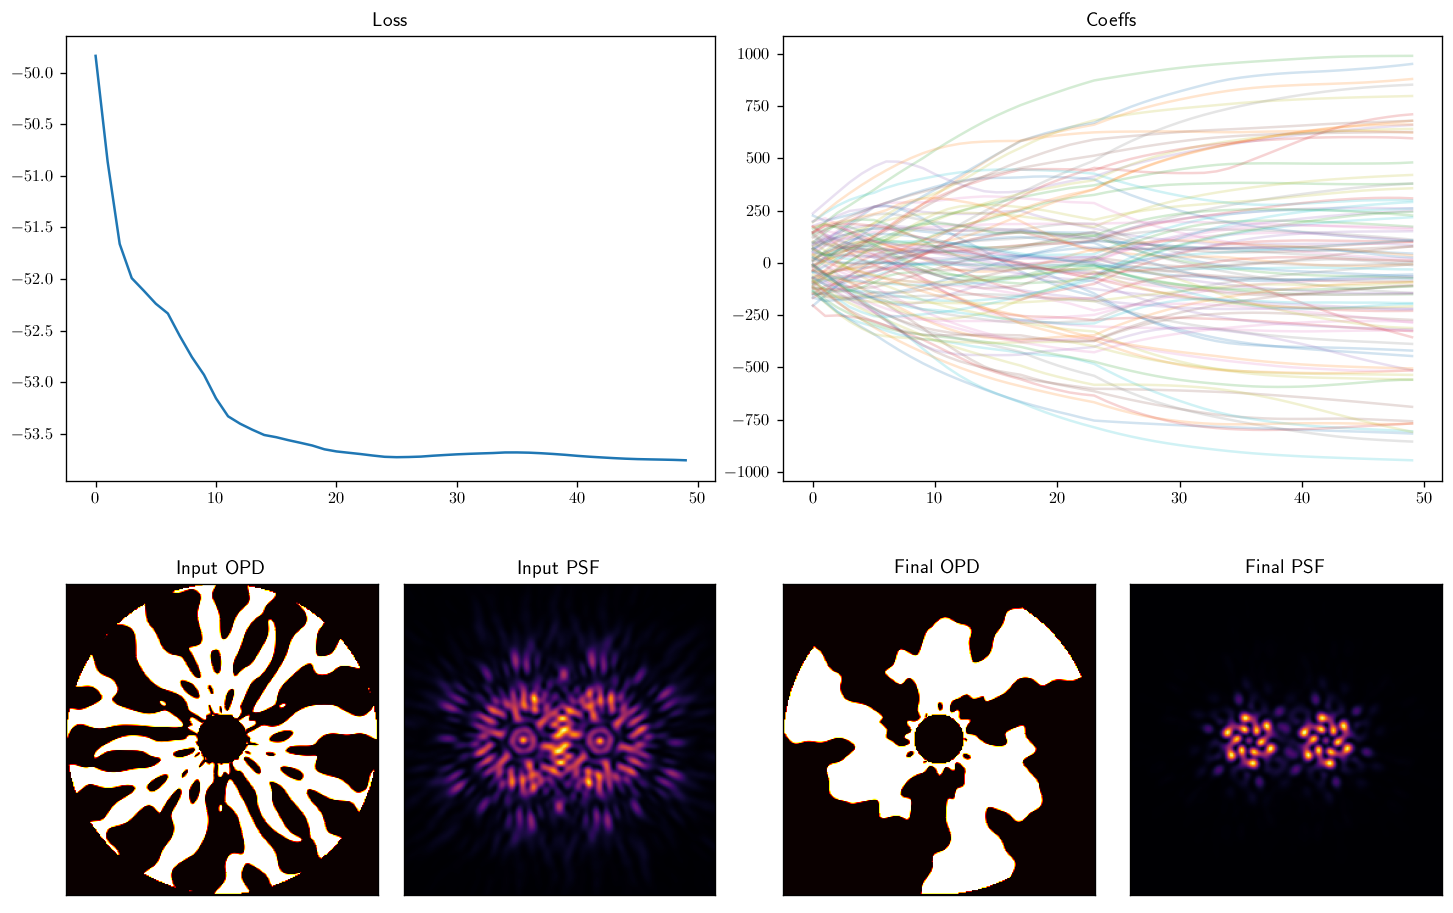

In [12]:
coeffs_out = np.array([model.layers[4].coeffs for model in models_out])

mosaic = """
    AABB
    CDEF
    """

fig = plt.figure(constrained_layout=True,figsize=(12, 8))
axes = fig.subplot_mosaic(mosaic)

for ax in ['C','D','E','F']:
    axes[ax].set_xticks([])
    axes[ax].set_yticks([])


axes['A'].plot(np.array(errors))
axes['A'].set_title("Loss")

axes['B'].set_title("Coeffs")
axes['B'].plot(coeffs_out[:], alpha=0.2)

model_in = osys
axes['C'].imshow(model_in.layers[2].array*model_in.layers[4].get_binary_phase(),cmap='hot')
axes['C'].set_title('Input OPD')

psf_in = model_in()
axes['D'].imshow(psf_in)
axes['D'].set_title('Input PSF')

final = models_out[-1]
axes['E'].imshow(final.layers[2].array*final.layers[4].get_binary_phase(),cmap='hot')
axes['E'].set_title('Final OPD')

psf_out = final()
axes['F'].imshow(psf_out)
axes['F'].set_title('Final PSF')

Let's calculate the covariance matrix elements:

In [13]:
%%time
covs = [calc_cov(poiss_logpri, X, dummy(), dummy, binary_param) for dummy in [model_in, final]]

CPU times: user 22.6 s, sys: 954 ms, total: 23.5 s
Wall time: 14.8 s


And using [ChainConsumer](https://samreay.github.io/ChainConsumer/) we can easily visualize this covariance:

/Users/louis/mambaforge/envs/dlux/lib/python3.10/site-packages/chainconsumer/chainconsumer.py:346: RuntimeWarning: covariance is not positive-semidefinite.
  chain = np.random.multivariate_normal(mean, covariance, size=1000000)


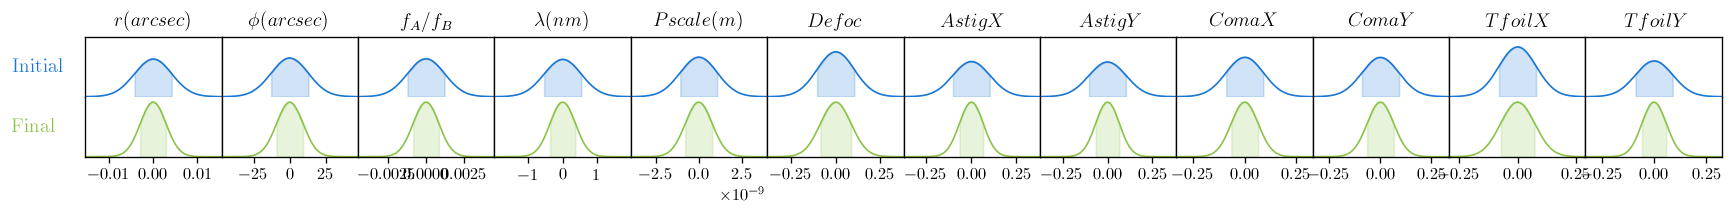

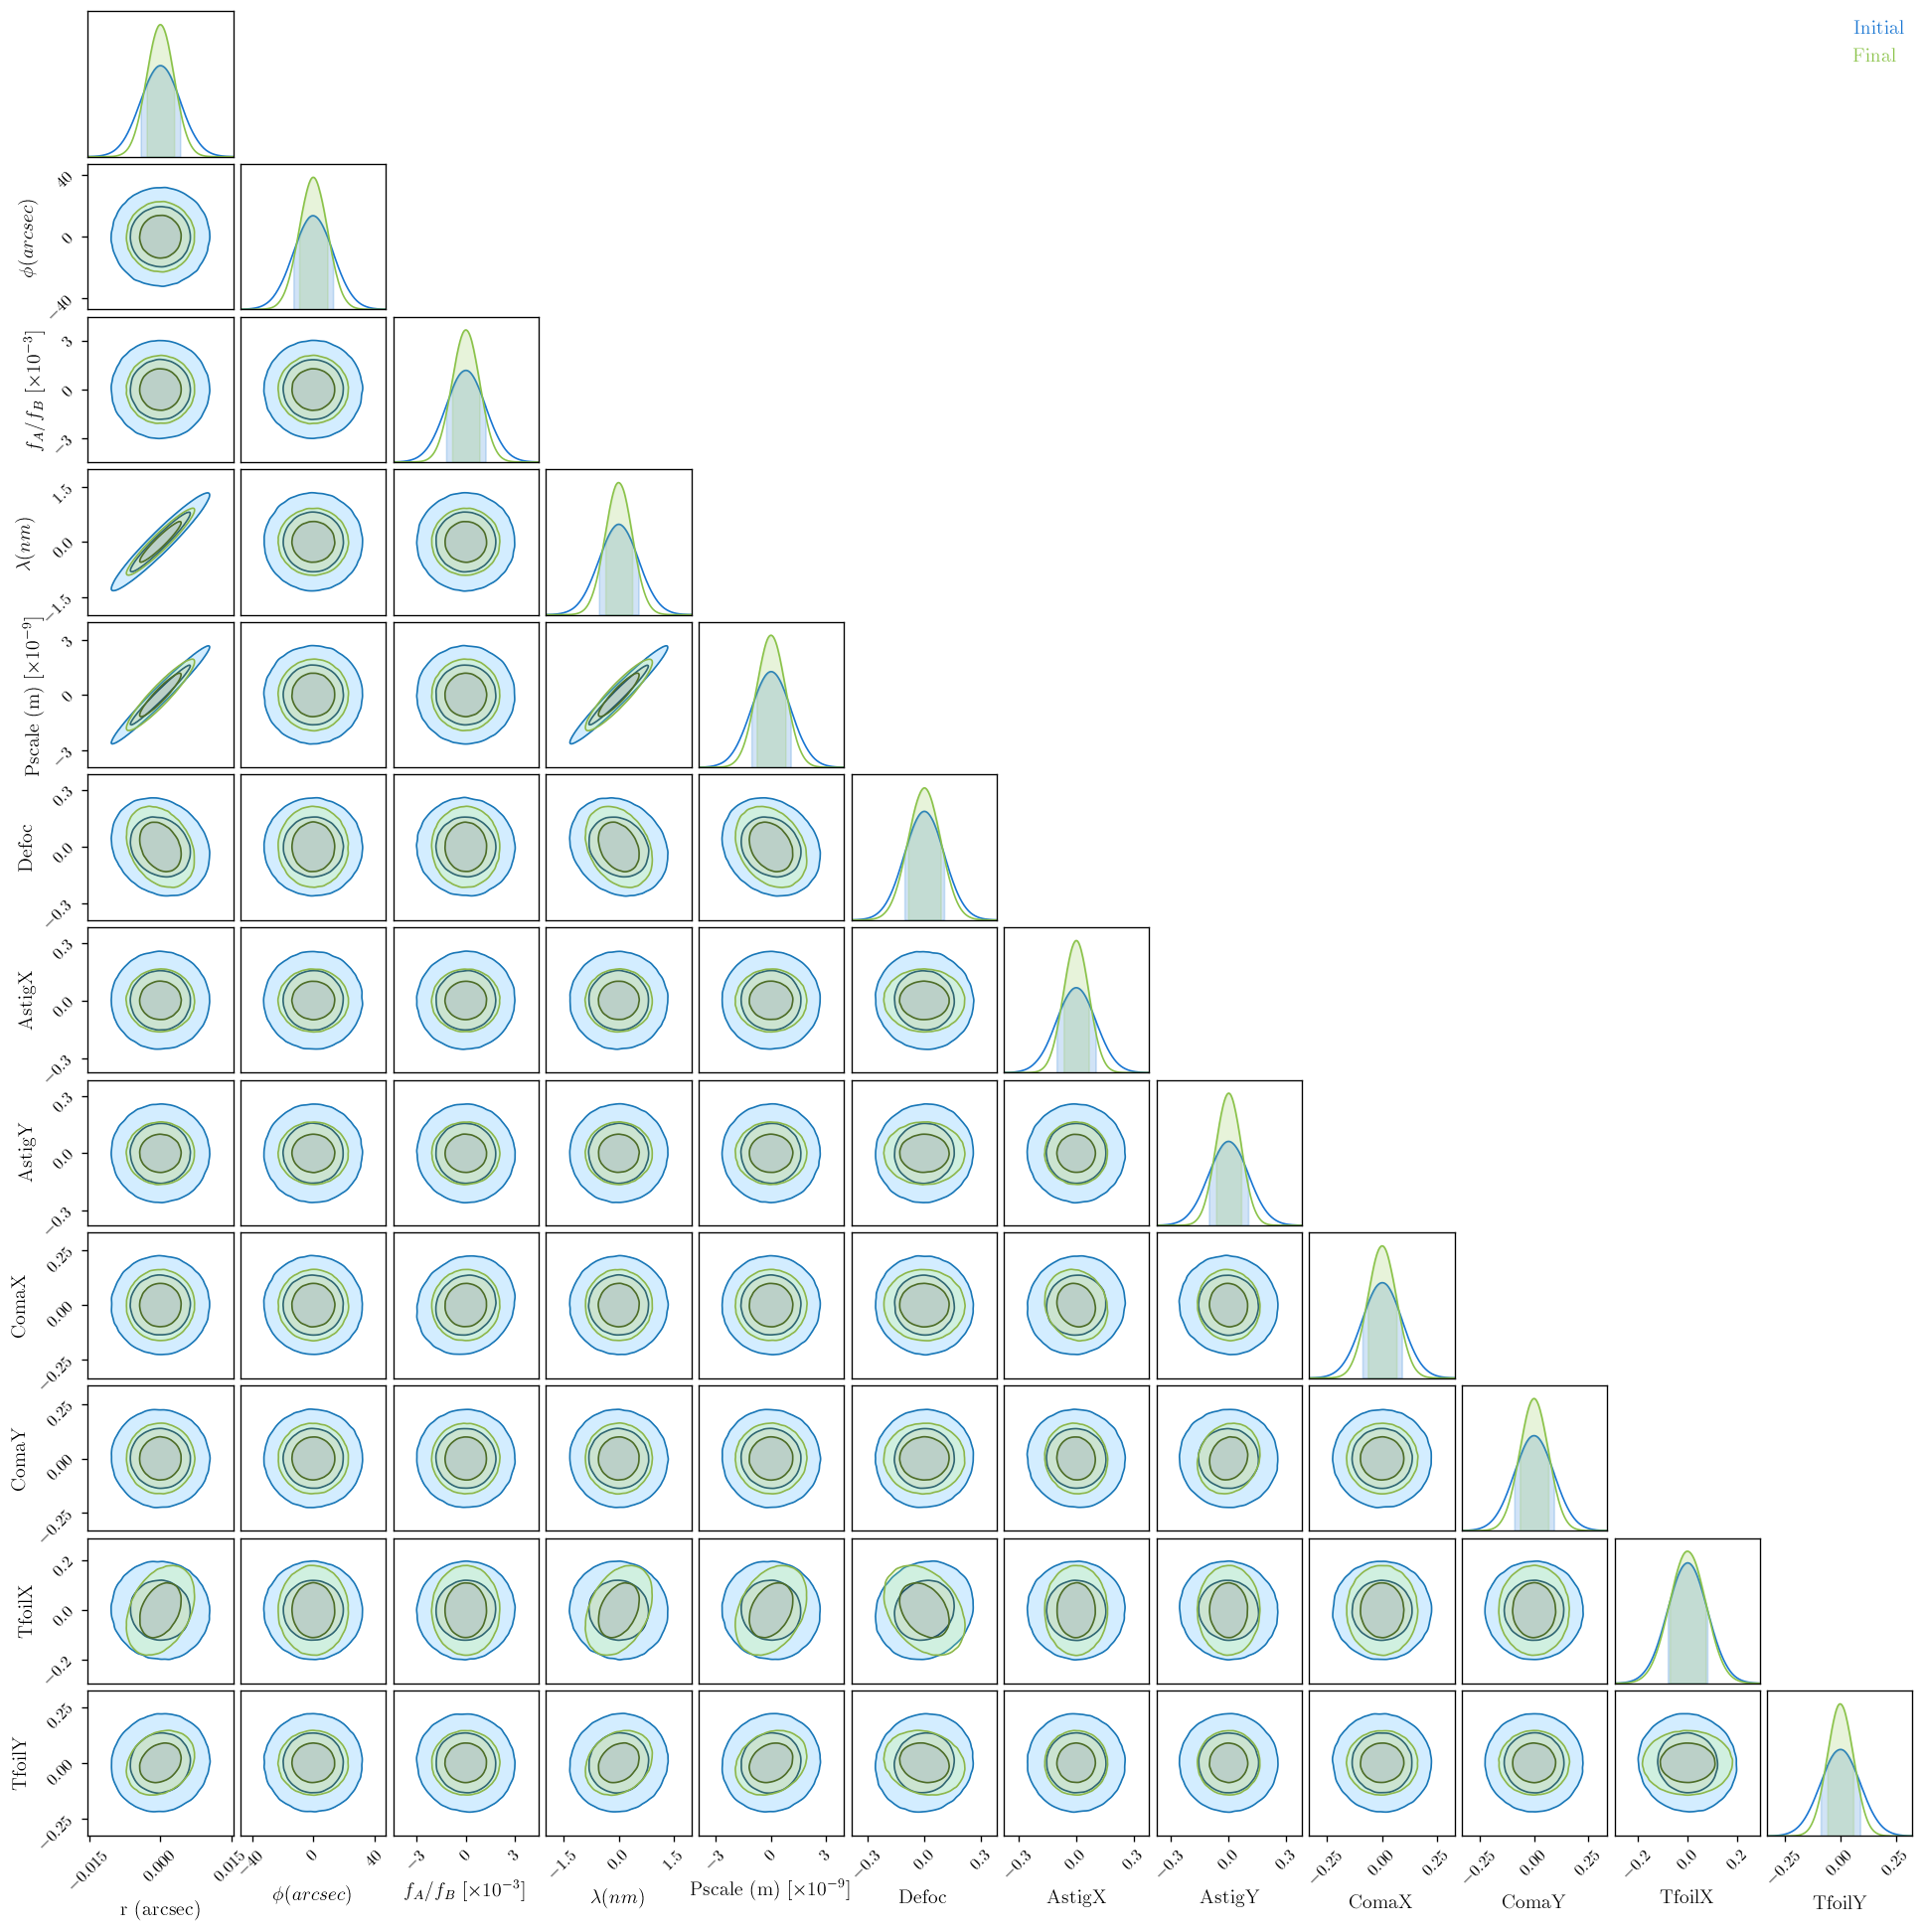

In [14]:
c = ChainConsumer()
c.add_covariance(X, covs[0], parameters=params,name='Initial')
c.add_covariance(X, covs[1], parameters=params,name='Final')


c.configure(serif=True, shade=True, bar_shade=True, shade_alpha=0.2, spacing=1., max_ticks=3)

fig = c.plotter.plot_summary()
fig = c.plotter.plot()

It looks like the optimization worked - marginal posterior bounds for all the optical parameters are *much* tighter after the optimization than they were before.

We see that in this narrowband simulation, most parameters aren't tightly correlated, but separation, plate scale and wavelength are almost indistinguishable - this makes sense, as they affect the PSF in the same way! Only independent constraints on λ can save us here. If you want to do precise astrometry, you have to nail down your plate scale and your spectrum: we see that the marginal posterior for separation is the same, but dominated entirely by this degeneracy with plate scale and λ, which is much tighter for the optimized pupil.

This is why in the Toliman telescope design we superimpose a grating over our pupil \([design paper, Fig 6](https://authors.library.caltech.edu/92050/1/107011J.pdf)\) - so we can measure a stellar spectrum and separate this from the astrometry.

If we were doing this properly for a telescope design, we would want to take this into account - our real goal is precisely measuring separation, and everything else is something we can just marginalize over. If we incorporate our prior constraints on plate scale and wavelength I am sure we will do even better.